## Libraries

Do not import any additional libraries

In [ ]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F

## Download dataset and create a data loader
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this assignment, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO, MNIST ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the CIFAR10 dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#download test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

#ReLU Units
# Define a CNN model with following layers: input > Conv > Pool > Conv > Pool > Linear > Output
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
#Sigmoid Units
# Define a CNN model with following layers: input > Conv > Pool > Conv > Pool > Linear > Output
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = self.pool(x)

        x = F.sigmoid(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model2 = CNN2().to(device)
print(model2)

CNN2(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
#negative log likelihood loss
loss_fn = nn.NLLLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters())
optimizer2 = torch.optim.Adam(model2.parameters())


## Training function

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

## Testing function

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

## Training process

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
epochs = 10
all_train_accuracies = []
all_test_accuracies = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    all_train_accuracies += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model, loss_fn)
    all_test_accuracies += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:24<03:41, 24.66s/it]

Epoch 1:	 Train accuracy: 50.6%	 Avg train loss: 1.379200	 Test accuracy: 60.5%	 Avg test loss: 1.107344


 20%|██        | 2/10 [00:41<02:41, 20.22s/it]

Epoch 2:	 Train accuracy: 64.2%	 Avg train loss: 1.012971	 Test accuracy: 65.8%	 Avg test loss: 0.957033


 30%|███       | 3/10 [00:58<02:11, 18.72s/it]

Epoch 3:	 Train accuracy: 70.9%	 Avg train loss: 0.825478	 Test accuracy: 69.0%	 Avg test loss: 0.892453


 40%|████      | 4/10 [01:16<01:51, 18.51s/it]

Epoch 4:	 Train accuracy: 76.4%	 Avg train loss: 0.674025	 Test accuracy: 70.2%	 Avg test loss: 0.888742


 50%|█████     | 5/10 [01:35<01:33, 18.65s/it]

Epoch 5:	 Train accuracy: 81.7%	 Avg train loss: 0.524116	 Test accuracy: 70.3%	 Avg test loss: 0.918573


 60%|██████    | 6/10 [01:54<01:14, 18.65s/it]

Epoch 6:	 Train accuracy: 86.3%	 Avg train loss: 0.390017	 Test accuracy: 70.1%	 Avg test loss: 0.985707


 70%|███████   | 7/10 [02:11<00:54, 18.26s/it]

Epoch 7:	 Train accuracy: 90.9%	 Avg train loss: 0.266434	 Test accuracy: 70.1%	 Avg test loss: 1.101087


 80%|████████  | 8/10 [02:29<00:36, 18.06s/it]

Epoch 8:	 Train accuracy: 94.0%	 Avg train loss: 0.175482	 Test accuracy: 68.5%	 Avg test loss: 1.313592


 90%|█████████ | 9/10 [02:48<00:18, 18.24s/it]

Epoch 9:	 Train accuracy: 95.5%	 Avg train loss: 0.133179	 Test accuracy: 69.7%	 Avg test loss: 1.438303


100%|██████████| 10/10 [03:05<00:00, 18.59s/it]

Epoch 10:	 Train accuracy: 96.5%	 Avg train loss: 0.103613	 Test accuracy: 69.4%	 Avg test loss: 1.558663


In [ ]:
epochs = 10
all_train_accuracies_2 = []
all_test_accuracies_2 = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model2, loss_fn, optimizer2)
    all_train_accuracies_2 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model2, loss_fn)
    all_test_accuracies_2 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10%|█         | 1/10 [00:18<02:48, 18.76s/it]

Epoch 1:	 Train accuracy: 30.7%	 Avg train loss: 1.889907	 Test accuracy: 42.2%	 Avg test loss: 1.608843


 20%|██        | 2/10 [00:36<02:24, 18.01s/it]

Epoch 2:	 Train accuracy: 46.5%	 Avg train loss: 1.491888	 Test accuracy: 50.5%	 Avg test loss: 1.380546


 30%|███       | 3/10 [00:53<02:04, 17.80s/it]

Epoch 3:	 Train accuracy: 52.9%	 Avg train loss: 1.318822	 Test accuracy: 53.8%	 Avg test loss: 1.288898


 40%|████      | 4/10 [01:12<01:48, 18.11s/it]

Epoch 4:	 Train accuracy: 56.6%	 Avg train loss: 1.209640	 Test accuracy: 54.9%	 Avg test loss: 1.235254


 50%|█████     | 5/10 [01:30<01:30, 18.06s/it]

Epoch 5:	 Train accuracy: 60.2%	 Avg train loss: 1.117677	 Test accuracy: 58.5%	 Avg test loss: 1.152440


 60%|██████    | 6/10 [01:49<01:13, 18.28s/it]

Epoch 6:	 Train accuracy: 63.2%	 Avg train loss: 1.033489	 Test accuracy: 60.4%	 Avg test loss: 1.118546


 70%|███████   | 7/10 [02:06<00:54, 18.07s/it]

Epoch 7:	 Train accuracy: 66.5%	 Avg train loss: 0.949932	 Test accuracy: 62.0%	 Avg test loss: 1.073123


 80%|████████  | 8/10 [02:24<00:35, 17.88s/it]

Epoch 8:	 Train accuracy: 69.5%	 Avg train loss: 0.866726	 Test accuracy: 63.2%	 Avg test loss: 1.048067


 90%|█████████ | 9/10 [02:42<00:18, 18.17s/it]

Epoch 9:	 Train accuracy: 72.3%	 Avg train loss: 0.790657	 Test accuracy: 65.0%	 Avg test loss: 1.010423


100%|██████████| 10/10 [03:00<00:00, 18.07s/it]

Epoch 10:	 Train accuracy: 75.1%	 Avg train loss: 0.717216	 Test accuracy: 65.6%	 Avg test loss: 0.995945


## Plot Results

Display the training and testing accuracy as a function of the number of epochs



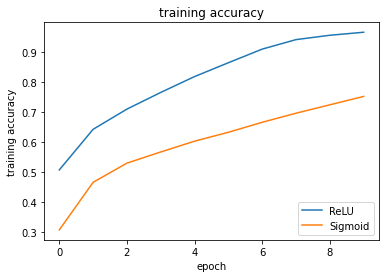

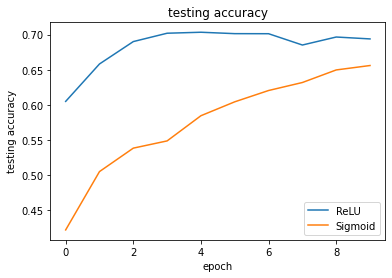

In [ ]:
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)

plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['ReLU','Sigmoid'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_2)

plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['ReLU','Sigmoid'], loc='lower right')
plt.show()


Explanation:

* As we can see from the training and testing accuracy plots, ReLU based trained CNN provides better training and testing accuracy compared to Sigmoid function based trained Neural network.
* The reason behind this could be thought as the Vanishing gradient issue with the Sigmoid based NN. It means some initial layers weights and biases are learnt very slowly when model uses Sigmoid function; as gradients for sigmoid function are always less than 1 and in the backpropogation of the losses some initial parameters do not get updated and adjusted properly even after certain number of epochs. Whereas, with ReLU based CNN, we have gradient values always 1 or 0, and this means backpropagation of losses will be much better and initial layers parrameters are also adjusted much faster and with less number of epochs.
* As we see from the graphs, we get maximum test accuracy with 3 to 4 epochs in ReLU based CNN, and we do not get near by accuracy level even after  10 epochs in Sigmoid based CNN. Howerver, we see that there is a continuous improvement in the test accuracy of Sigmoid based CNN model with the number of epochs, so may be after several more epochs we may get its test accuracy comparable to what we achieve best through the ReLU based CNN model. Moreover, calculating gradients for ReLU is comparatively much cheaper compared to sigmoid function. So, due to these two reasons, Sigmoid based NN model is quite expensive to train compared to ReLU based NN model.